In [65]:
import torch 
import torchvision
from torchvision import datasets, models
from torchvision.transforms import v2
import torch.utils
import torch.utils.data
import torch.utils.data.dataloader
import torch.nn as nn
import torch.optim as optim
import time
import os
import copy


class ImageClassNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.model = nn.Sequential(
            nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 64, out_channels = 64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(in_channels = 256, out_channels = 256, kernel_size = 1, stride = 1, padding = 0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2),
            nn.Flatten(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features = 7*7*256, out_features = 512),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features = 512, out_features = 256),
            nn.ReLU(),
            nn.Linear(in_features = 256, out_features = 10)
        )
        
        self.init_weight()

    def init_weight(self):
        for layer in self.model:
            if isinstance(layer, nn.Conv2d):
                nn.init.kaiming_uniform_(layer.weight, mode = 'fan_out', nonlinearity = 'relu')
                # nn.init.normal_(layer.weight, 0, std= 0.01)
                nn.init.constant_(layer.bias, 0)
            if isinstance(layer, nn.Linear):
                # nn.init.normal_(layer.weight, 0, std= 0.01)
                nn.init.kaiming_uniform_(layer.weight, mode = 'fan_out', nonlinearity = 'relu')
                nn.init.constant_(layer.bias, 0)
    
    def forward(self, x):
        return self.model(x)
    



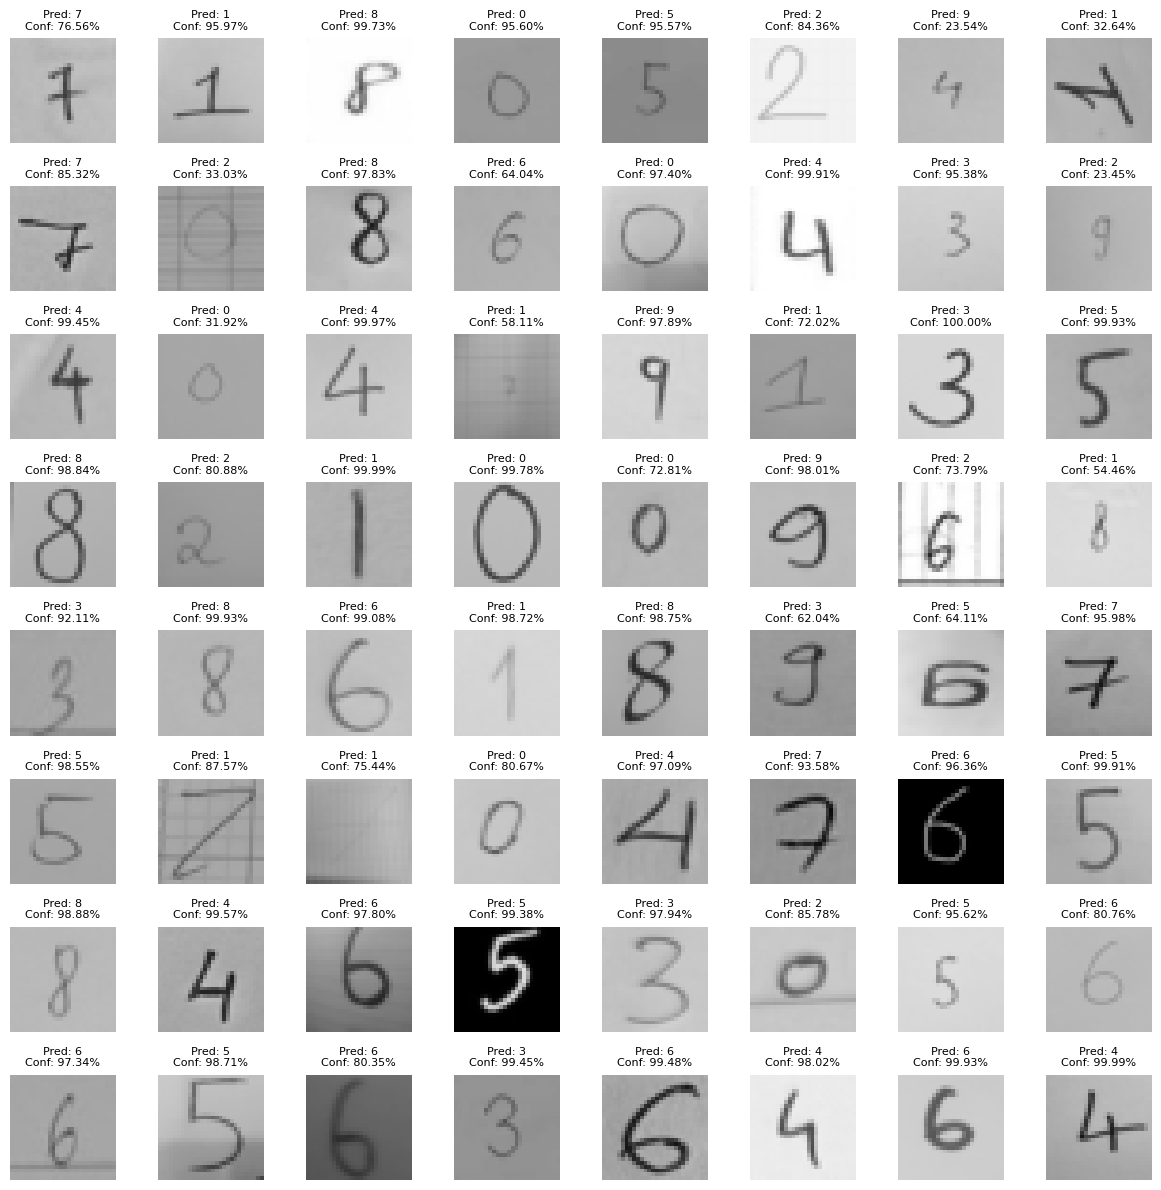

In [66]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from pillow_heif import register_heif_opener
import torch.nn.functional as F
register_heif_opener()

# Define a custom dataset class
class UnlabeledImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        if img_name.endswith('.md'):
            # return [0.0,0.0,0.0], "None"  # Skip images with .md format
            return torch.zeros([3,28,28]), img_name
        
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Assuming necessary imports and definitions (ImageClassNet, UnlabeledImageDataset, transform) are already in place

transform = v2.Compose([
    v2.Resize((28, 28)),
    # v2.Normalize(mean = [0.6280, 0.6273, 0.6217], std = [0.2107, 0.2106, 0.2055]),
    v2.Grayscale(num_output_channels=3),
    v2.ToTensor(),
    # transforms.Normalize([0.6269, 0.6269, 0.6269], [0.2096, 0.2096, 0.2096])
])

# Load the model
model = ImageClassNet()
model.load_state_dict(torch.load('best_model8.pth'))
model.eval()

# Create the dataset and dataloader
dataset = UnlabeledImageDataset('Dataset/cs114.o21.x.lab01-competition', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Load a batch of images
image_batch, name_batch = next(iter(dataloader))

# Filter out any None images
filtered_images = []
filtered_names = []

for img, name in zip(image_batch, name_batch):
    if img is not None:
        filtered_images.append(img)
        filtered_names.append(name)

# Convert list to tensor
image_batch = torch.stack(filtered_images)
name_batch = filtered_names

# Make predictions
with torch.no_grad():
    outputs = model(image_batch)
    probabilities = F.softmax(outputs, dim=1)  # Compute softmax probabilities
    confidence, predicted = torch.max(probabilities, 1)  # Get the max confidence and predicted label

# Plot the batch of images with their predicted labels and confidence
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
axes = axes.flatten()

for img, label, conf, ax in zip(image_batch, predicted, confidence, axes):
    img = img.permute(1, 2, 0)  # Permute dimensions to (height, width, channel) for plotting
    img = img.squeeze()  # Remove channel dimension if grayscale image
    ax.imshow(img, cmap='gray')  # Add cmap='gray' for grayscale images
    ax.set_title(f'Pred: {label.item()}\nConf: {conf.item()*100:.2f}%', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()


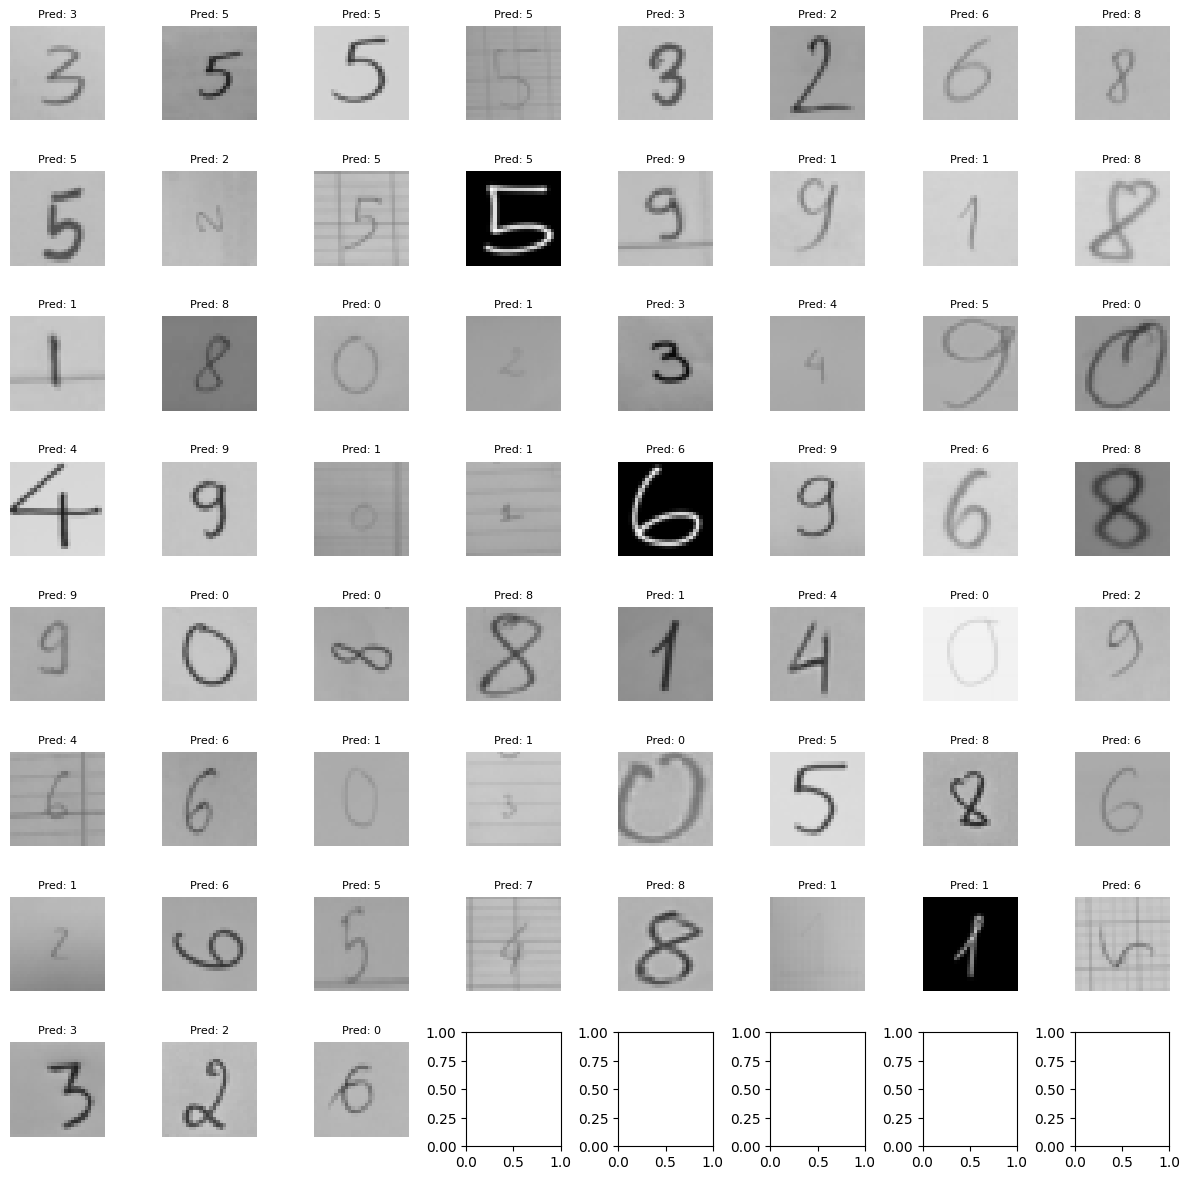

In [72]:
import os
import csv
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from pillow_heif import register_heif_opener
register_heif_opener()

def predict_cnn(model, images):
    model.eval()
    with torch.no_grad():
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
    return predicted


# Define a custom dataset class
class UnlabeledImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        if img_name.endswith('.md'):
            # return [0.0,0.0,0.0], "None"  # Skip images with .md format
            return torch.zeros([3,28,28]), "None"
        
        img_path = os.path.join(self.image_dir, img_name)
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, img_name

# Define the transformation to apply to the images
transform = transforms.Compose([
    v2.Resize((28, 28)),
    v2.Grayscale(),
    v2.RGB(),
    v2.ToTensor(),
])



model0 = ImageClassNet()
model0.load_state_dict(torch.load('best_model5.pth'))
model0.eval()

model1 = ImageClassNet()
model1.load_state_dict(torch.load('best_model6.pth'))
model1.eval()

model2 = ImageClassNet()
model2.load_state_dict(torch.load('best_model7.pth'))
model2.eval()

model3 = ImageClassNet()
model3.load_state_dict(torch.load('best_model8.pth'))
model3.eval()

model4 = ImageClassNet()
model4.load_state_dict(torch.load('best_model9.pth'))
model4.eval()

# cnn_models = [model0, model1, model2, model3, model4]
cnn_models = [model2, model3, model4]

# Create the dataset and dataloader
dataset = UnlabeledImageDataset('Dataset/cs114.o21.x.lab01-competition', transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

# Create a CSV file to store the results
with open('predictions.csv', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['FileName', 'PredictedLabel'])
    
    for image_batch, name_batch in dataloader:
        # Filter out any None images
        filtered_images = []
        filtered_names = []
        for img, name in zip(image_batch, name_batch):
            if img is not None:
                filtered_images.append(img)
                filtered_names.append(name)

        # Convert list to tensor
        image_batch = torch.stack(filtered_images)
        name_batch = filtered_names

        with torch.no_grad():
            # Get predictions from each CNN
            all_predictions = []
            for model in cnn_models:
                predictions = predict_cnn(model, image_batch)
                all_predictions.append(predictions.unsqueeze(1))

            # Stack predictions and take majority vote (or average for regression)
            stacked_predictions = torch.cat(all_predictions, dim=1)
            final_predictions = torch.mode(stacked_predictions, dim=1)[0]

        # Write the predictions to the CSV file
        for name, prediction in zip(name_batch, final_predictions):
            csvwriter.writerow([name, prediction.item()])

# Plot the batch of images with their predicted labels
fig, axes = plt.subplots(8, 8, figsize=(12, 12))
axes = axes.flatten()

for img, label, ax in zip(image_batch, final_predictions, axes):
    img = img.squeeze()  # Remove channel dimension for grayscale image
    img = img.permute(1, 2, 0)
    ax.imshow(img)
    ax.set_title(f'Pred: {label.item()}', fontsize=8)
    ax.axis('off')

plt.tight_layout()
plt.show()
